## TOAD构建标准评分卡模型

### 0、数据准备

这里使用的数据是著名的德国信用卡数据集。数据预处理包括:

(1) 将target从'good' / 'bad'替换为0,1;  
(2) 划分训练集测试集;  
(3) 增加一列表示训练和测试的特征。训练集将用于建模，而测试集将仅用于验证。  

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import toad

In [2]:
data = pd.read_csv('./data/german_credit.csv')
data.rename(columns={'default':'creditability'},inplace=True)

print(data.shape) # 1000 data and 20 features 
data.head()

(1000, 21)


,creditability,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [3]:
data.columns

Index(['creditability', 'account_check_status', 'duration_in_month',
       'credit_history', 'purpose', 'credit_amount', 'savings',
       'present_emp_since', 'installment_as_income_perc',
       'personal_status_sex', 'other_debtors', 'present_res_since', 'property',
       'age', 'other_installment_plans', 'housing', 'credits_this_bank', 'job',
       'people_under_maintenance', 'telephone', 'foreign_worker'],
      dtype='object')

划分训练集和测试集：

In [4]:
Xtr,Xts,Ytr,Yts = train_test_split(data.drop('creditability',axis=1),data['creditability'],test_size=0.25,random_state=450)
data_tr = pd.concat([Xtr,Ytr],axis=1)
#增加一列区分训练/测试的特征
data_tr['type'] = 'train'
data_ts = pd.concat([Xts,Yts],axis=1)
data_ts['type'] = 'test'

### 1、EDA数据处理

Toad支持常用的特征EDA分析，包括检测缺失值和特征分布。  

`toad.detector.detect()`:返回每个特性的EDA报告，包括数据类型、分布、缺失率和惟一值。

In [5]:
toad.detector.detect(data_tr).head(10)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
account_check_status,object,750,0.00%,4,no checking account:39.20%,< 0 DM:27.60%,0 <= ... < 200 DM:27.07%,>= 200 DM / salary assignments for at least 1 ...,None,None,no checking account:39.20%,< 0 DM:27.60%,0 <= ... < 200 DM:27.07%,>= 200 DM / salary assignments for at least 1 ...
duration_in_month,int64,750,0.00%,32,20.548,11.941,4,6,8,18,24,36,60,72
credit_history,object,750,0.00%,5,existing credits paid back duly till now:53.73%,critical account/ other credits existing (not ...,delay in paying off in the past:8.00%,all credits at this bank paid back duly:4.93%,no credits taken/ all credits paid back duly:3...,existing credits paid back duly till now:53.73%,critical account/ other credits existing (not ...,delay in paying off in the past:8.00%,all credits at this bank paid back duly:4.93%,no credits taken/ all credits paid back duly:3...
purpose,object,750,0.00%,10,domestic appliances:27.47%,car (new):25.33%,radio/television:18.40%,business:9.33%,car (used):9.20%,(vacation - does not exist?):5.07%,education:2.67%,repairs:1.07%,furniture/equipment:0.93%,retraining:0.53%
credit_amount,int64,750,0.00%,700,3207.35,2731.93,250,417.33,906.3,2301.5,3956.5,7179.4,12715.2,15672
savings,object,750,0.00%,5,... < 100 DM:60.93%,unknown/ no savings account:17.47%,100 <= ... < 500 DM:10.53%,500 <= ... < 1000 DM :6.00%,.. >= 1000 DM :5.07%,... < 100 DM:60.93%,unknown/ no savings account:17.47%,100 <= ... < 500 DM:10.53%,500 <= ... < 1000 DM :6.00%,.. >= 1000 DM :5.07%
present_emp_since,object,750,0.00%,5,1 <= ... < 4 years:32.53%,.. >= 7 years:24.93%,... < 1 year :18.67%,4 <= ... < 7 years:17.60%,unemployed:6.27%,1 <= ... < 4 years:32.53%,.. >= 7 years:24.93%,... < 1 year :18.67%,4 <= ... < 7 years:17.60%,unemployed:6.27%
installment_as_income_perc,int64,750,0.00%,4,2.94533,1.13493,1,1,1,3,4,4,4,4
personal_status_sex,object,750,0.00%,4,male : single:54.40%,female : divorced/separated/married:30.80%,male : married/widowed:9.33%,male : divorced/separated:5.47%,None,None,male : single:54.40%,female : divorced/separated/married:30.80%,male : married/widowed:9.33%,male : divorced/separated:5.47%
other_debtors,object,750,0.00%,3,none:90.80%,guarantor:4.93%,co-applicant:4.27%,None,None,None,None,none:90.80%,guarantor:4.93%,co-applicant:4.27%


### 2、特征粗筛选

Toad可以用来过滤大量的特征，如高缺失率、低iv和高度相关的特征。它还可以使用各种分箱技巧进行分箱和实现WOE转化。

`toad.selection.select()`:用于根据缺失百分比、iv(20箱)和多重共线性(带有VIF和/或自相关)来过滤特征。

下面以缺失率大于0.5、IV值小于0.05或者相关性大于0.7(保留较高的特征)来进行特征筛选。

In [6]:
selected_data, drop_lst= toad.selection.select(data_tr,target = 'creditability', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['type'])

selected_test = data_ts[selected_data.columns]

print(selected_data.shape)
drop_lst 

(750, 16)


{'empty': array([], dtype=float64),
 'iv': array(['installment_as_income_perc', 'present_res_since',
        'credits_this_bank', 'job', 'people_under_maintenance',
        'telephone'], dtype=object),
 'corr': array([], dtype=object)}

可以看到，6个特征由于IV值过低被剔除。

`toad.quality(dataframe, target)`:返回每个特征的质量，包括iv、基尼系数和熵。可以帮助我们发现更有用的潜在信息。

In [7]:
quality = toad.quality(data,'creditability')
quality.head(6)

,iv,gini,entropy,unique
account_check_status,0.666012,0.368037,0.545196,4.0
duration_in_month,0.354784,0.406755,0.609659,33.0
credit_amount,0.351455,0.408680,0.610864,921.0
credit_history,0.293234,0.394090,0.580631,5.0
age,0.211197,0.414339,0.610863,53.0
savings,0.196010,0.404838,0.591377,5.0


### 3、分箱

#### 3.1 第一步：分箱

`toad.transform.Combiner()`:可以用来对数值型和类别型变量进行分箱，支持决策树分箱、卡方分箱、最优分箱等。该行代码生成一个Combiner类，这个类有以下方法：   
- `combiner().fit(data, y = 'target', method = 'chi', min_samples = None, n_bins = None )`: 分箱，支持卡方、决策树、等频和等宽。
- `combiner().set_rules(dict)`: 设置箱号。 
- `combiner().transform(data)`: 将特征的值转化为分箱的箱号。

In [8]:
# 初始化一个combiner类
combiner = toad.transform.Combiner()

# 训练数据并指定分箱方法，其它参数可选
combiner.fit(selected_data, y='creditability', method='chi', min_samples =  0.05, exclude='type')

# 以字典形式保存分箱结果
bins = combiner.export() 

#查看每个特征的分箱结果
print('account_check_status:',bins['account_check_status'])
print('credit_amount:',bins['credit_amount'])
print('duration_in_month:', bins['duration_in_month'])

account_check_status: [['no checking account'], ['>= 200 DM / salary assignments for at least 1 year'], ['0 <= ... < 200 DM'], ['< 0 DM']]
credit_amount: [2145, 3914]
duration_in_month: [9, 12, 18, 33]


#### 3.2 第二步：分箱可视化

- `toad.plot.badrate_plot(data,target = 'target', x = None, by = None)`: 画出不同数据集的每一箱的bad_rate图。这里可以是训练集测试集，也可以不同月份的对比。by后面是纵轴。x是需要对比的维度，比如训练集测试集、不同的月份。  
- `toad.plot.proportion_plot(datacol)`: 画出一个特征每一箱的比例。

In [9]:
# 根据bad_rate图调整分箱

# 比如查看duration.in.month这个变量的分箱情况
adj_bin = {'duration_in_month': [9, 12, 18, 33]}

c2 = toad.transform.Combiner()
c2.set_rules(adj_bin)

data_ = pd.concat([data_tr,data_ts],axis = 0)
temp_data = c2.transform(data_[['duration_in_month','creditability','type']])

from toad.plot import badrate_plot, proportion_plot
badrate_plot(temp_data, target = 'creditability', x = 'type', by = 'duration_in_month') 
proportion_plot(temp_data['duration_in_month'])

第一张图是训练集和测试集下每一箱对应的坏样本率，第二张图是每一箱的占比情况。可以看到第一张图中的第一箱和第二箱的bad_rate存在倒挂，说明bad_rate不单调，需要进行调整。可以尝试将第一箱和第二箱进行合并。

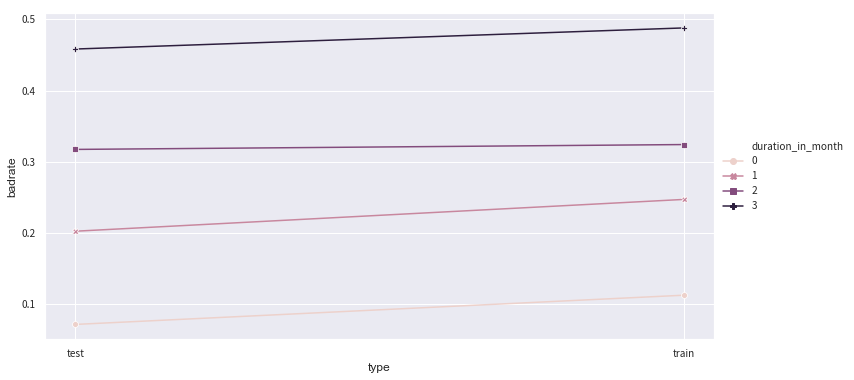

In [10]:
# 假定将第一箱、第二箱合并
adj_bin = {'duration_in_month': [9, 18, 33]}
c2.set_rules(adj_bin)

temp_data = c2.transform(data_[['duration_in_month','creditability','type']])
badrate_plot(temp_data, target = 'creditability', x = 'type', by = 'duration_in_month')

adj_bin = {'duration_in_month': [9, 18,33], 'foreign_worker': [['no'], ['yes']]}

调整之后可以看到分箱的bad_rate大致呈现单调的趋势。

使用bin_plot()画图对分箱进行调整

使用bin_plot对样本集分箱进行调整，使用bad_rate验证分箱在测试集或者跨时间验证集上的稳定性。

No handles with labels found to put in legend.
No handles with labels found to put in legend.


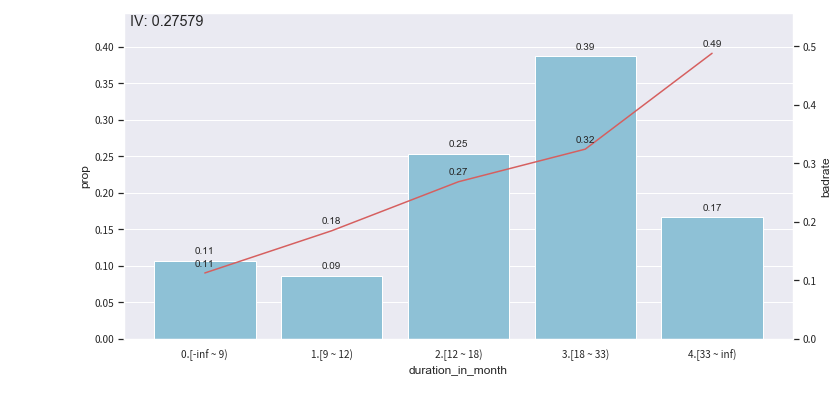

In [11]:
from toad.plot import bin_plot

transformed = combiner.transform(data_tr,labels=True)
# 传给bin_plot的数据必须是分箱转化之后的
bin_plot(transformed,x='duration_in_month',target='creditability')

柱形图表示每一箱的占比，折线图表示每一箱的坏样本率。一般折线图要呈现出单调的趋势。

再看一个对类别型变量分箱进行调整的例子。对类别型变量进行分箱的时候，易出现某个类别只有好样本/坏样本，这样对计算WOE值造成问题，所以需要将只有好/坏样本的箱进行合并。

No handles with labels found to put in legend.
No handles with labels found to put in legend.


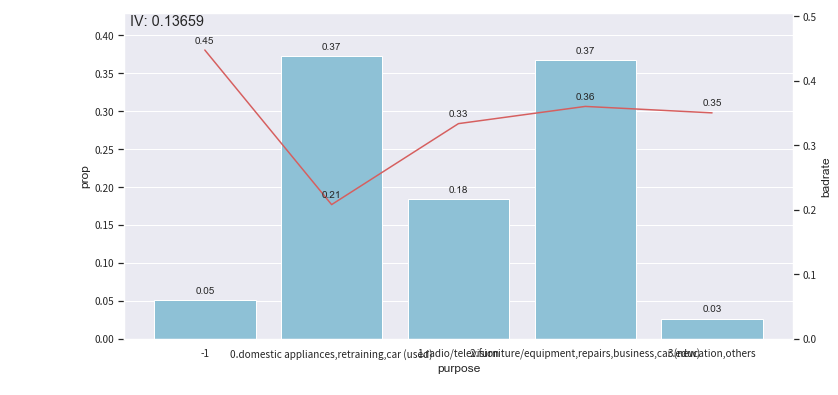

In [12]:
# 分箱合并
c2.set_rules({'purpose': [['domestic appliances','retraining','car (used)'], ['radio/television'], ['furniture/equipment','repairs','business','car (new)'], ['education','others']]})
bin_plot(c2.transform(data_tr[['purpose','creditability']],labels=True),x='purpose',target='creditability')

### 4、WOE转化

`toad.transform.WOETransformer()`: 构造WOE转换器  
`WOETransformer().fit_transform(data, y_true, exclude = None)`：对分箱后的数据进行WOE转化

In [13]:
#设置分箱号 
combiner.set_rules(adj_bin)

#将特征的值转化为分箱的箱号。
binned_data = combiner.transform(selected_data)

#计算WOE
transer = toad.transform.WOETransformer()

#对WOE的值进行转化，映射到原数据集上。对训练集用fit_transform,测试集用transform.
data_tr_woe = transer.fit_transform(binned_data, binned_data['creditability'], exclude=['creditability','type'])
data_ts_woe = transer.transform(combiner.transform(selected_test))

### 5、特征选择

`toad.selection.stepwise()`: 可以通过向前、向后、双向选择来进行特征选择，使用AIC/BIC/KS/AUC作为选择标准。

In [52]:
final_data = toad.selection.stepwise(data_tr_woe.drop('type',axis=1), target = 'creditability', direction = 'both', criterion = 'aic')

final_test = data_ts_woe[final_data.columns]
print(final_data.shape)
print(final_data.columns)

C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\zh\Anaconda3\li

(750, 9)
Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'personal_status_sex', 'property', 'age',
       'other_installment_plans', 'creditability'],
      dtype='object')


C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\zh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\zh\Anaconda3\li

可以看到经过模型选择，14个特征减少为8个特征。

### 6、建模

In [55]:
Xtr = final_data.drop('creditability',axis=1)
Ytr = final_data['creditability']
Xts = final_test.drop('creditability',axis=1)
Yts = final_test['creditability']

lr = LogisticRegression(class_weight='balance')
lr.fit(Xtr, Ytr)

LogisticRegression(C=1.0, class_weight='balance', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 7、模型评估和验证

#### 7.1 常用的评估指标如KS、F1、AUC

In [56]:
from toad.metrics import KS, F1, AUC

EYtr_proba = lr.predict_proba(Xtr)[:,1]
EYtr = lr.predict(Xtr)

print('Training error')
print('F1:', F1(EYtr_proba,Ytr))
print('KS:', KS(EYtr_proba,Ytr))
print('AUC:', AUC(EYtr_proba,Ytr))

EYts_proba = lr.predict_proba(Xts)[:,1]
EYts = lr.predict(Xts)

print('\nTest error')
print('F1:', F1(EYts_proba,Yts))
print('KS:', KS(EYts_proba,Yts))
print('AUC:', AUC(EYts_proba,Yts))

Training error
F1: 0.4536082474226804
KS: 0.4922717969019803
AUC: 0.8115118639499331

Test error
F1: 0.45079365079365086
KS: 0.471480535562263
AUC: 0.7781131491370638


#### 7.2 PSI 比较训练集和测试集各变量的稳定性

In [17]:
psi = toad.metrics.PSI(final_data, final_test)
psi.sort_values(0,ascending=False) # Further tune the unstable feature if any 

purpose                    0.053175
duration_in_month          0.038424
age                        0.017464
property                   0.014331
credit_history             0.012744
personal_status_sex        0.008780
account_check_status       0.001251
creditability              0.000545
other_installment_plans    0.000047
dtype: float64

#### 7.3 模型报告

In [22]:
tr_bucket = toad.metrics.KS_bucket(EYtr_proba, Ytr, bucket=20, method='quantile')
tr_bucket_desc = tr_bucket.sort_values(by='min', ascending=False).reset_index(drop=True)
tr_bucket_desc

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,total_prop,cum_bads,cum_goods,cum_total,cum_bads_prop,cum_goods_prop,cum_total_prop,ks
0,0.741303,0.918317,25,13,38,0.657895,0.342105,1.923077,0.110132,0.024857,0.050667,227,523,750,1.000000,1.000000,1.000000,0.000000
1,0.659747,0.739702,30,7,37,0.810811,0.189189,4.285714,0.132159,0.013384,0.049333,202,510,712,0.889868,0.975143,0.949333,-0.085276
2,0.588524,0.656414,20,18,38,0.526316,0.473684,1.111111,0.088106,0.034417,0.050667,172,503,675,0.757709,0.961759,0.900000,-0.204050
3,0.532306,0.587709,25,12,37,0.675676,0.324324,2.083333,0.110132,0.022945,0.049333,152,485,637,0.669604,0.927342,0.849333,-0.257739
4,0.483812,0.530962,20,18,38,0.526316,0.473684,1.111111,0.088106,0.034417,0.050667,127,473,600,0.559471,0.904398,0.800000,-0.344926
5,0.428909,0.481983,18,19,37,0.486486,0.513514,0.947368,0.079295,0.036329,0.049333,107,455,562,0.471366,0.869981,0.749333,-0.398615
6,0.359375,0.425231,15,23,38,0.394737,0.605263,0.652174,0.066079,0.043977,0.050667,89,436,525,0.392070,0.833652,0.700000,-0.441582
7,0.323305,0.359107,14,23,37,0.378378,0.621622,0.608696,0.061674,0.043977,0.049333,74,413,487,0.325991,0.789675,0.649333,-0.463684
8,0.274298,0.322566,9,29,38,0.236842,0.763158,0.310345,0.039648,0.055449,0.050667,60,390,450,0.264317,0.745698,0.600000,-0.481381
9,0.241290,0.274218,7,30,37,0.189189,0.810811,0.233333,0.030837,0.057361,0.049333,51,361,412,0.224670,0.690249,0.549333,-0.465579


In [26]:
from pyecharts.charts import *  
from pyecharts import options as opts  
from pylab import *  

mpl.rcParams['font.sans-serif'] = ['SimHei']  
np.set_printoptions(suppress=True)  
pd.set_option('display.unicode.ambiguous_as_wide', True)  
pd.set_option('display.unicode.east_asian_width', True)  

line = (  
  
    Line()  
    .add_xaxis(list(tr_bucket_desc.index))  
    .add_yaxis(  
        "分组坏人占比",  
        list(np.round(tr_bucket_desc.bad_rate,2)),  
        yaxis_index=0,  
        color="red",  
    )  
    .set_global_opts(  
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),  
    )  
    .extend_axis(  
        yaxis=opts.AxisOpts(  
            name="累计坏人占比",  
            type_="value",  
            min_=0,  
            max_=0.5,  
            position="right",  
            axisline_opts=opts.AxisLineOpts(  
                linestyle_opts=opts.LineStyleOpts(color="red")  
            ),  
            axislabel_opts=opts.LabelOpts(formatter="{value}"),  
        )  
  
    )  
    .add_xaxis(list(tr_bucket_desc.index))  
    .add_yaxis(  
        "KS",  
        list(-tr_bucket_desc.ks),  
        yaxis_index=1,  
        color="blue",  
        label_opts=opts.LabelOpts(is_show=False),  
    )  
)  
line.render_notebook()  

### 8、分数转换

输出每个变量的得分情况

In [21]:
card = toad.scorecard.ScoreCard(combiner = combiner, transer = transer, C = 0.1) 
card.fit(Xtr, Ytr)
card.export(to_frame = True,).head(10)

,name,score,value
0,account_check_status,135.36,no checking account
1,account_check_status,93.25,>= 200 DM / salary assignments for at least 1 ...
2,account_check_status,38.87,0 <= ... < 200 DM
3,account_check_status,10.43,< 0 DM
4,duration_in_month,137.00,[-inf ~ 9)
5,duration_in_month,80.02,[9 ~ 18)
6,duration_in_month,57.29,[18 ~ 33)
7,duration_in_month,16.14,[33 ~ inf)
8,credit_history,91.16,critical account/ other credits existing (not ...
9,credit_history,61.14,existing credits paid back duly till now
